# <font color = 'green'>Sentinel 2 indices using Python</font>

This notebook wants to show how to use Sentinel data to calculate various indices


Thanks to Syamkakarla for his interesting notebook:
https://github.com/syamkakarla98/Satellite_Imagery_Analysis/blob/main/code/Sundarbans_Satellite_Imagery_Analysis_using_Python.ipynb

# Import Modules

In [1]:
from glob import glob

import numpy as np
np.seterr(divide='ignore', invalid='ignore')

import earthpy as et
from earthpy.plot import plot_bands, plot_rgb, hist

import rasterio 
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

import plotly.graph_objects as go
import os

In [2]:
# normalized difference between 2 bands
def nom_diff(band1, band2):
    band1 = band1.astype(float)
    band2 = band2.astype(float)
    return (band1-band2)/(band1+band2)

## Sentinel 2 images
![title](Sentinel_2_bands.PNG)

Source: https://en.wikipedia.org/wiki/Sentinel-2

### Example Sundarbans Satellite Data

In [3]:
cwd = os.getcwd()
bands = glob(os.path.join(cwd,"data/*(Raw).tiff"))
bands.sort()

In [4]:
# read all available images with rasterio library
images = []
for i in bands:
  with rasterio.open(i, 'r') as f:
    band = f.read(1)
    images.append(band)

In [5]:
# stack images as n dimensional array
arrImages = np.stack(images)

In [6]:
# check size
arrImages.shape

(12, 482, 625)

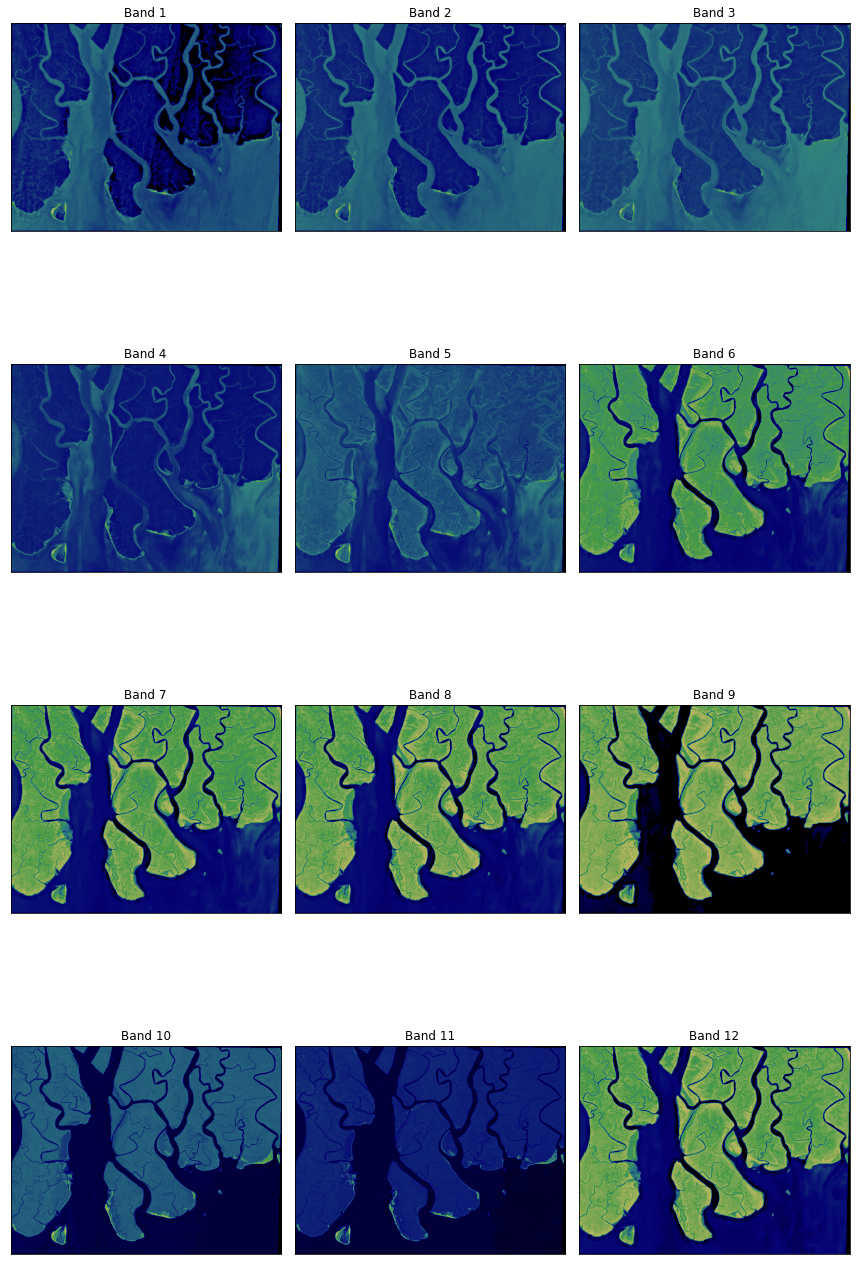

In [7]:
# Quick plot of the 12 bands by passing a 3 dimensional array (nb images, height, width)
plot_bands(arrImages, cmap = 'gist_earth', figsize = (12, 20), cols = 3, cbar = False)
plt.show()

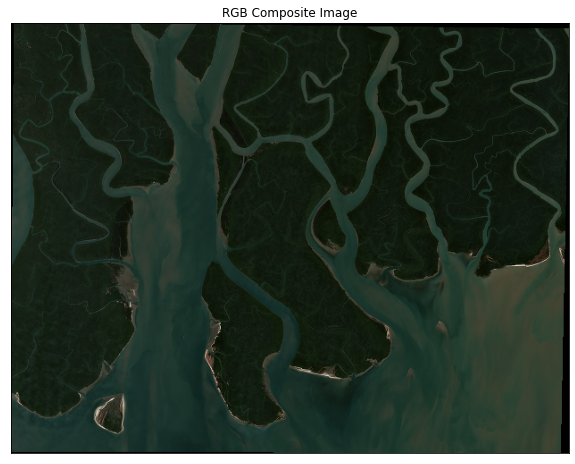

In [8]:
# To get insights from the previous images we can create a RGB image from the red-green-bands respectively band 4-3-2 
# (3-2-1 for python 0 indexed convention ) 
rgb = plot_rgb(arrImages, 
                  rgb=(3,2,1), 
                  figsize=(10, 16), 
                  title='RGB Composite Image'
                  )

plt.show()

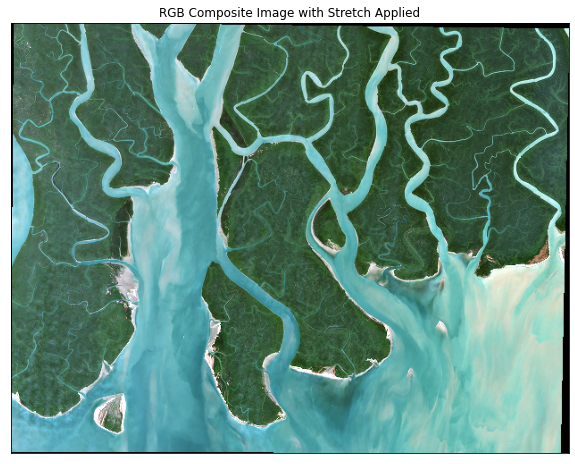

In [9]:
# The composed RGB images can be dark if the pixel brightness is skewed toward 0.
# The brightness, however, can be enhanced by stretching the pixel brightness values to the full 0-255 possible values.
# This can be done by setting in the function "plot_rgb" the argument stretch to "True" and by specifying with the str_clip argument
# how much of the data you want to clip off

plot_rgb(
    arrImages,
    rgb=(3, 2, 1),
    stretch=True,
    str_clip=0.4,
    figsize=(10, 16),
    title="RGB Composite Image with Stretch Applied",
)

plt.show()

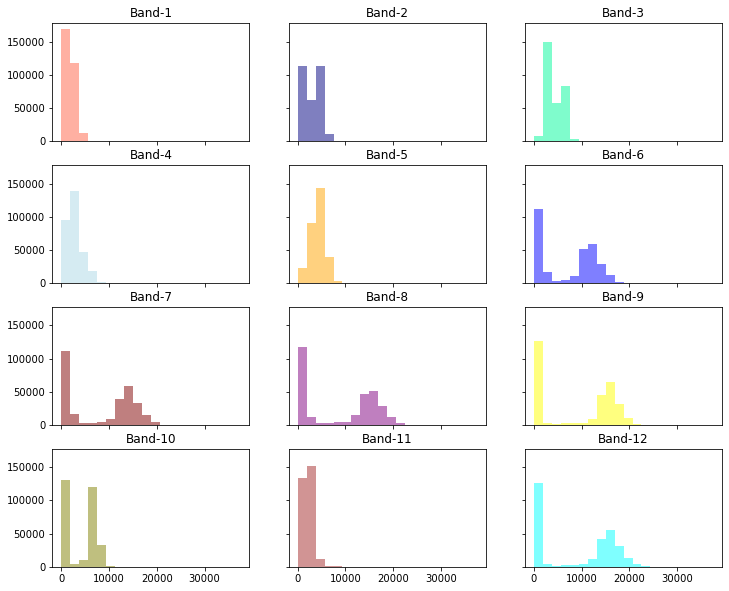

In [10]:
# Show histograms for each bands
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

hist(arrImages, 
         colors = colors,
         title=[f'Band-{i}' for i in range(1, 13)], 
         cols=3, 
         alpha=0.5, 
         figsize = (12, 10)
         )

plt.show()

# Vegetation and soils indices

Source: https://www.space4water.org/

## Normalized Difference Vegetation Index (NDVI)
```
NDVI = ((NIR - Red)/(NIR + Red))
```

* NIR = pixel values from the near-infrared band
* Red = pixel values from the red band

Negative values of NDVI (values approaching -1) correspond to water. Values close to zero (-0.1 to 0.1) generally correspond to barren areas of rock, sand, or snow. Lastly, low, positive values represent shrub and grassland (approximately 0.2 to 0.4), while high values indicate temperate and tropical rainforests (values approaching 1).

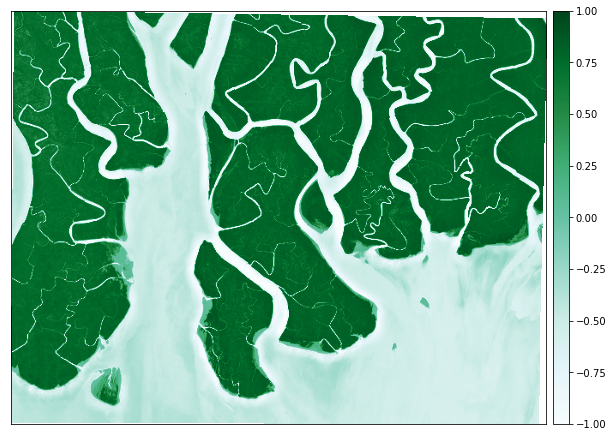

In [11]:
# Note. It is important to convert to float type before calculating indices otherwise we will have wrong calculations with uint type
arrImages = arrImages.astype(float)
ndvi = et.spatial.normalized_diff(arrImages[7], arrImages[3])

plot_bands(ndvi, cmap="BuGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))

plt.show()

## Soil-Adjusted Vegetation Index (SAVI) 

```
SAVI = ((NIR - Red) / (NIR + Red + L)) x (1 + L)
```
* NIR = pixel values from the near infrared band
* Red = pixel values from the near red band
* L = amount of green vegetation cover

SAVI is used to correct Normalized Difference Vegetation Index (NDVI) for the influence of soil brightness in areas where vegetative cover is low. The L value varies depending on the amount of green vegetative cover. Generally, it has the following values:
- L=1 in areas with no green vegetation cover
- L=0.5 in areas of moderate green vegetative cover
- L= 0 in areas with very high vegetation cover

In [12]:
L = 0.5

savi = ((arrImages[7] - arrImages[3]) / (arrImages[7] + arrImages[3] + L)) * (1 + L)

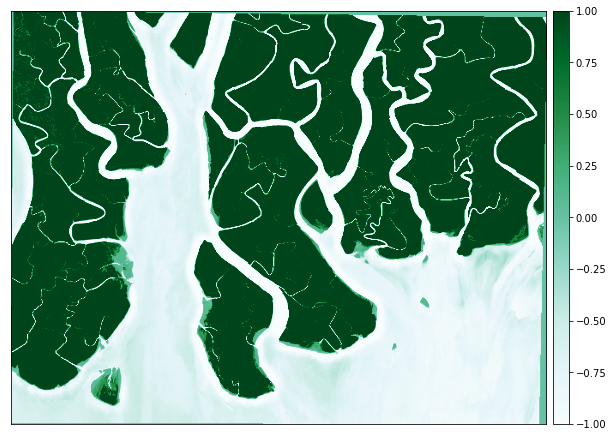

In [13]:
plot_bands(savi, cmap="BuGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))

plt.show()

## Visible Atmospherically Resistant Index (VARI)
```
VARI = (Green - Red)/ (Green + Red - Blue)
```
* Green = pixel values from the green band
* Red= pixel values from the red band
* Blue = pixel values from the blue band

The Visible Atmospherically Resistant Index (VARI) is designed to emphasize vegetation in the visible portion of the spectrum, while mitigating illumination differences and atmospheric effects. It is ideal for RGB or color images; it utilizes all three color bands

In [14]:
vari = (arrImages[2] - arrImages[3])/ (arrImages[2] + arrImages[3] - arrImages[1])

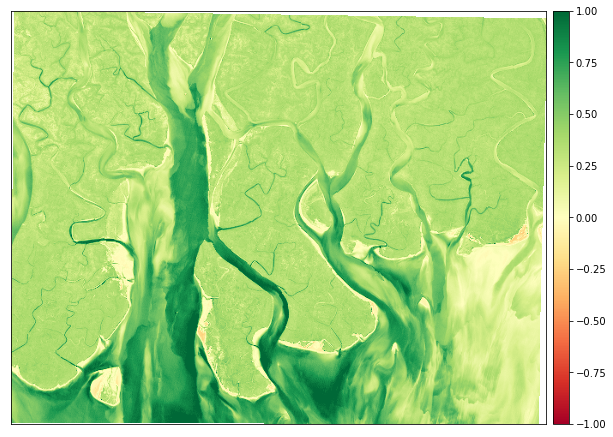

In [15]:
plot_bands(vari, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))

plt.show()

## Distribution of NDVI, SAVI, and VARI pixel values

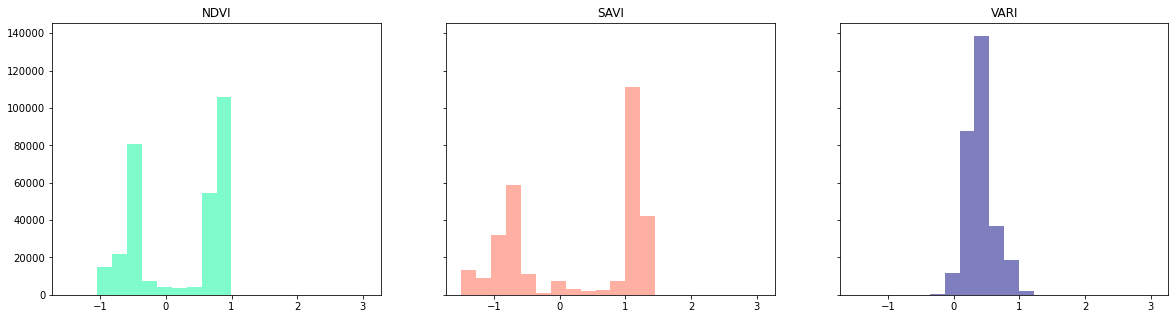

In [16]:
hist(np.stack([ndvi, savi, vari]), 
        alpha=0.5,
        cols=3, 
        figsize=(20, 5),
        title = ['NDVI', 'SAVI', 'VARI'],
        colors = ['mediumspringgreen', 'tomato', 'navy'])
plt.show()

# Water Indices

## Modified Normalized Difference Water Index (MNDWI) 

It is used to monitor changes related to water content in water bodies.

```
MNDWI = (Green - SWIR) / (Green + SWIR)
```
* Green = pixel values from the green band
* SWIR = pixel values from the short-wave infrared band

The NDWI is used to monitor changes related to water content in water bodies. As water bodies strongly absorb light in visible to infrared electromagnetic spectrum, NDWI uses green and near infrared bands to highlight water bodies. It is sensitive to built-up land and can result in over-estimation of water bodies. 
Values description: Index values greater than 0.5 usually correspond to water bodies. Vegetation usually corresponds to much smaller values and built-up areas to values between zero and 0.2.
Source: https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndwi/

In [17]:
mndwi = et.spatial.normalized_diff(arrImages[2], arrImages[10])

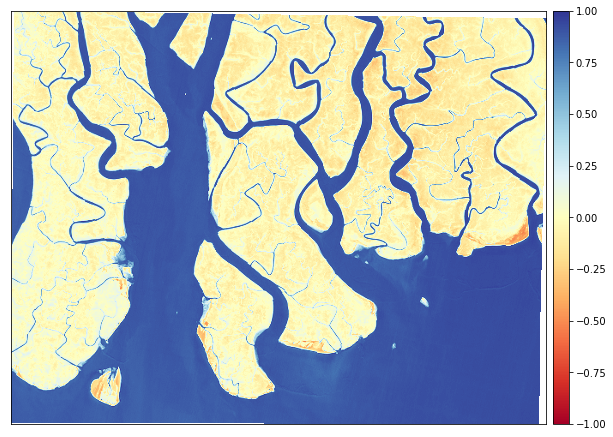

In [18]:
et.plot.plot_bands(mndwi, cmap="RdYlBu", cols=1, vmin=-1, vmax=1, figsize=(10, 14))

plt.show()

## Normalized Difference Moisture Index (NDMI) 

```
NDMI = (NIR - SWIR1)/(NIR + SWIR1)
```
* NIR = pixel values from the near infrared band
* SWIR1 = pixel values from the short-wave infrared 1 band

In [19]:
ndmi = et.spatial.normalized_diff(arrImages[7], arrImages[10])

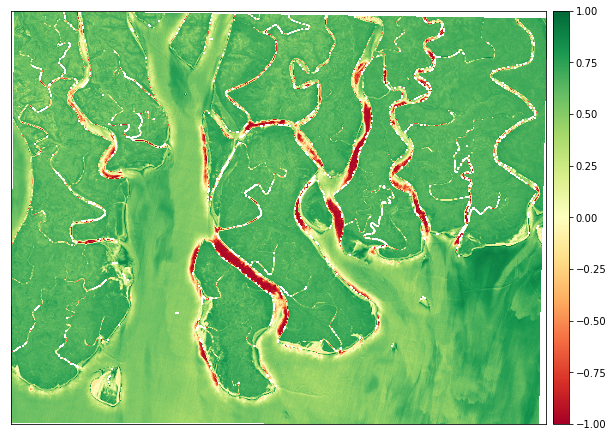

In [20]:
et.plot.plot_bands(ndmi, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))

plt.show()

# Geology Indices

## Clay Minerals
```
Clay Minerals Ratio = SWIR1 / SWIR2
```
* SWIR1 = pixel values from the short-wave infrared 1 band
* SWIR2 = pixel values from the short-wave infrared 2 band

In [21]:
cmr = np.divide(arrImages[10], arrImages[11])

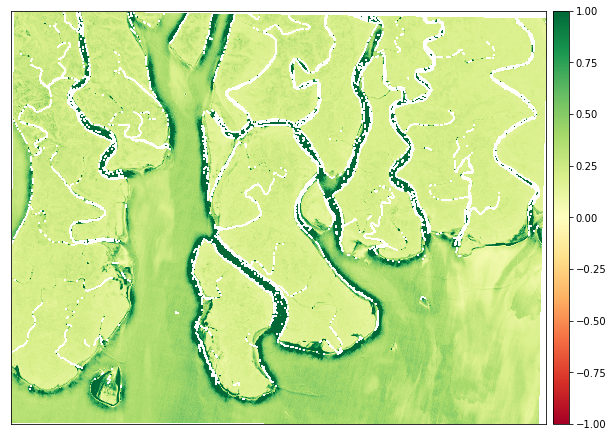

In [22]:
et.plot.plot_bands(cmr, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))

plt.show()

## Ferrous Minerals

```
Ferrous Minerals Ratio = SWIR / NIR
```

* SWIR= pixel values from the short-wave infrared band
* NIR = pixel values from the near infrared band

In [23]:
fmr = np.divide(arrImages[10], arrImages[7])

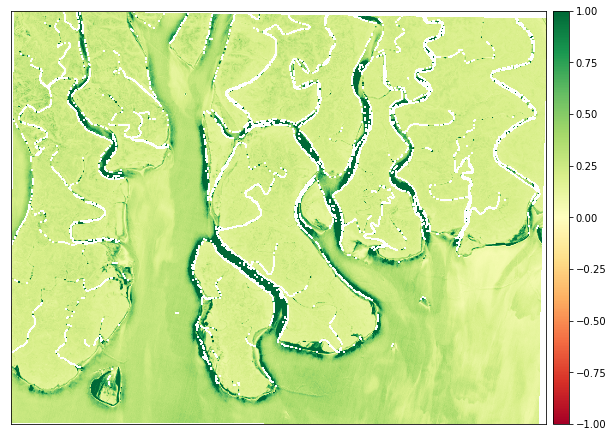

In [24]:
et.plot.plot_bands(fmr, cmap="RdYlGn", cols=1, vmin=-1, vmax=1, figsize=(10, 14))

plt.show()